# MSG Pipeline Walkthrough

In this demo, we will do a full walkthrough of a minimal MSG pipeline to get some data for training

In [1]:
import autoroot
from rs_tools._src.utils.io import get_list_filenames
import rioxarray
import xarray as xr
import pandas as pd
import numpy as np
from satpy import Scene
from pathlib import Path
from typing import List, Tuple, Dict
from rs_tools._src.data.modis.bands import MODIS_VARIABLES
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID, get_modis_paired_files
from rs_tools._src.geoprocessing.msg.reproject import add_msg_crs

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dataclasses import dataclass
from tqdm.auto import tqdm
from datetime import datetime
from loguru import logger

%matplotlib inline
%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_dir_raw = "/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/"
save_dir_analysis = "/Users/anna.jungbluth/Desktop/git/rs_tools/data/analysis/"
save_dir_mlready = "/Users/anna.jungbluth/Desktop/git/rs_tools/data/mlready/"

## 1 - Download Data

In [12]:
start_date = "2020-10-01"
end_date = "2020-10-01"
start_time = "15:05:00"
end_time = "16:05:00"
time_step = "00:15:00"
instrument = "HRSEVIRI"

In [15]:
eumdac_key=''
eumdac_secret=''

In [2]:
from rs_tools._src.data.msg.download import msg_download

#### Radiance Data

In [14]:
msg_download(
    start_date=start_date,
    end_date=end_date,
    start_time=start_time,
    end_time=end_time,
    time_step=time_step,
    instrument=instrument,
    save_dir=save_dir_raw,
    eumdac_key=eumdac_key,
    eumdac_secret=eumdac_secret
)

2024-03-21 14:27:53.939 | INFO     | rs_tools._src.data.msg.download:_check_eumdac_login:225 - EUMDAC login successful. Token '652ea05f-a4b8-3807-a3c4-e214ac62966d' expires 2024-03-21 15:26:03.780747
2024-03-21 14:27:53.939 | INFO     | rs_tools._src.data.msg.download:msg_download:95 - Data Product: EO:EUM:DAT:MSG:HRSEVIRI


Times to check:  2020-10-01 15:05:00 2020-10-01 15:50:00


Time - 2020-10-01 15:20:00:  25%|██▌       | 1/4 [01:00<03:01, 60.61s/it]

Successfully downloaded MSG4-SEVI-MSG15-0100-NA-20201001151243.638000000Z-NA.nat.
['/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSG15-0100-NA-20201001151243.638000000Z-NA.nat']


Time - 2020-10-01 15:35:00:  50%|█████     | 2/4 [02:13<02:15, 67.90s/it]

Successfully downloaded MSG4-SEVI-MSG15-0100-NA-20201001152743.698000000Z-NA.nat.
['/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSG15-0100-NA-20201001152743.698000000Z-NA.nat']


Time - 2020-10-01 15:50:00:  75%|███████▌  | 3/4 [03:43<01:18, 78.17s/it]

Successfully downloaded MSG4-SEVI-MSG15-0100-NA-20201001154243.758000000Z-NA.nat.
['/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSG15-0100-NA-20201001154243.758000000Z-NA.nat']


Time - 2020-10-01 15:50:00: 100%|██████████| 4/4 [05:14<00:00, 78.68s/it]

Successfully downloaded MSG4-SEVI-MSG15-0100-NA-20201001155743.818000000Z-NA.nat.
['/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSG15-0100-NA-20201001155743.818000000Z-NA.nat']


['/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSG15-0100-NA-20201001151243.638000000Z-NA.nat',
 '/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSG15-0100-NA-20201001152743.698000000Z-NA.nat',
 '/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSG15-0100-NA-20201001154243.758000000Z-NA.nat',
 '/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSG15-0100-NA-20201001155743.818000000Z-NA.nat']

#### Cloud Mask

In [20]:
start_time = "15:00:00"
end_time = "16:15:00"
instrument = "CLM"

In [21]:
msg_download(
    start_date=start_date,
    end_date=end_date,
    start_time=start_time,
    end_time=end_time,
    time_step=time_step,
    instrument=instrument,
    save_dir=save_dir_raw,
    eumdac_key=eumdac_key,
    eumdac_secret=eumdac_secret
)

2024-03-21 14:35:55.075 | INFO     | rs_tools._src.data.msg.download:_check_eumdac_login:224 - EUMDAC login successful. Token '652ea05f-a4b8-3807-a3c4-e214ac62966d' expires 2024-03-21 15:26:02.899527
2024-03-21 14:35:55.076 | INFO     | rs_tools._src.data.msg.download:msg_download:95 - Data Product: EO:EUM:DAT:MSG:CLM


Times to check:  2020-10-01 15:00:00 2020-10-01 16:00:00


Time - 2020-10-01 15:15:00:  20%|██        | 1/5 [00:03<00:14,  3.67s/it]

Successfully downloaded MSG4-SEVI-MSGCLMK-0100-0100-20201001150000.000000000Z-NA.grb.


Time - 2020-10-01 15:30:00:  40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Successfully downloaded MSG4-SEVI-MSGCLMK-0100-0100-20201001151500.000000000Z-NA.grb.


Time - 2020-10-01 15:45:00:  60%|██████    | 3/5 [00:15<00:11,  5.64s/it]

Successfully downloaded MSG4-SEVI-MSGCLMK-0100-0100-20201001153000.000000000Z-NA.grb.


Time - 2020-10-01 16:00:00:  80%|████████  | 4/5 [00:20<00:05,  5.38s/it]

Successfully downloaded MSG4-SEVI-MSGCLMK-0100-0100-20201001154500.000000000Z-NA.grb.


Time - 2020-10-01 16:00:00: 100%|██████████| 5/5 [00:25<00:00,  5.07s/it]

Successfully downloaded MSG4-SEVI-MSGCLMK-0100-0100-20201001160000.000000000Z-NA.grb.


['/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSGCLMK-0100-0100-20201001150000.000000000Z-NA.grb',
 '/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSGCLMK-0100-0100-20201001151500.000000000Z-NA.grb',
 '/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSGCLMK-0100-0100-20201001153000.000000000Z-NA.grb',
 '/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSGCLMK-0100-0100-20201001154500.000000000Z-NA.grb',
 '/Users/anna.jungbluth/Desktop/git/rs_tools/data/raw/MSG4-SEVI-MSGCLMK-0100-0100-20201001160000.000000000Z-NA.grb']

For this case, we are going to download MSG data.

**Resources**:
* EUMETSAT Downloader - [Webpage](https://user.eumetsat.int/dashboard)

In [3]:
def parse_msg_dates_from_file(file: str):
    """
    Parses the date and time information from a MSG file name.

    Args:
        file (str): The file name to parse.

    Returns:
        str: The parsed date and time in the format 'YYYYJJJHHMM'.
    """
    timestamp = Path(file).name.split("-")[-2]
    timestamp = timestamp.split(".")[0]
    return timestamp

In [5]:
msg_files = get_list_filenames("/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/", ".nat")
msg_files_clouds = get_list_filenames("/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/", ".grb")
msg_files, msg_files_clouds

(['/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/L1b/MSG4-SEVI-MSG15-0100-NA-20201001151243.638000000Z-NA.nat',
  '/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/L1b/MSG4-SEVI-MSG15-0100-NA-20201001152743.698000000Z-NA.nat',
  '/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/L1b/MSG4-SEVI-MSG15-0100-NA-20201001154243.758000000Z-NA.nat',
  '/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/L1b/MSG4-SEVI-MSG15-0100-NA-20201001155743.818000000Z-NA.nat',
  '/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/L1b/MSG4-SEVI-MSG15-0100-NA-20201002141243.994000000Z-NA.nat',
  '/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/L1b/MSG4-SEVI-MSG15-0100-NA-20201002142742.310000000Z-NA.nat'],
 ['/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/CM/MSG4-SEVI-MSGCLMK-0100-0100-20201001150000.000000000Z-NA.grb',
  '/Users/anna.jungbluth/Desktop/git/rs_tools/data/msg/CM/MSG4-SEVI-MSGCLMK-0100-0100-20201001151500.000000000Z-NA.grb',
  '/Users/anna.jungbluth/Desktop/git/rs_tools/dat

In [6]:
unique_times_radiances = list(set(map(parse_msg_dates_from_file, msg_files)))
unique_times_cloudmask = list(set(map(parse_msg_dates_from_file, msg_files_clouds)))

In [7]:
unique_times_cloudmask, unique_times_radiances

(['20201001151500',
  '20201001153000',
  '20201001154500',
  '20201001160000',
  '20201002140000',
  '20201002141500',
  '20201001150000',
  '20201002143000'],
 ['20201001152743',
  '20201001151243',
  '20201002141243',
  '20201002142742',
  '20201001154243',
  '20201001155743'])

In [8]:
def match_timestamps(times_data: List[str], times_clouds: List[str], cutoff: int=15) -> pd.DataFrame:
    """
    Matches timestamps of data and cloudmask files, if not measured at exactly the same time.

    Args:
        times_data (List[str]): Timestamps of data files.
        times_clouds (List[str]): Timestamps of the cloud mask files.
        cutoff (str, optional): Maximum time difference in minutes to consider a match. Defaults to 15.

    Returns:
        pd.DataFrame: A DataFrame with the matched timestamps.
    """
    timestamps_data = pd.to_datetime(times_data)
    timestamps_clouds = pd.to_datetime(times_clouds)

    matches_data = []
    matches_clouds = []

    for time in timestamps_data:
        closest_time = timestamps_clouds[
            np.abs((timestamps_clouds - time).total_seconds()).argmin()
        ]
        if np.abs((closest_time - time).total_seconds()) <= pd.Timedelta(f'{cutoff}min').total_seconds():
            matches_data.append(time.strftime("%Y%m%d%H%M%S"))
            matches_clouds.append(closest_time.strftime("%Y%m%d%H%M%S"))
        else:
            logger.info(f"No matching cloud mask found for {time}")

    matched_times = pd.DataFrame({
        "timestamps_data": matches_data,
        "timestamps_cloudmask": matches_clouds
    })
            
    return matched_times

In [9]:
df = match_timestamps(unique_times_radiances, unique_times_cloudmask)

## 2 - Loading Data

1. Get All Files
2. Create MSGFileName Identifiers
3. Filter Based on criteria

In [10]:
# you can load multiple files, but then the data is stacked along the y-axis, which is not corrent
scn = Scene(reader="seviri_l1b_native", filenames=[msg_files[0]])

In [11]:
# MSG data contains 12 channels, including the high-resolution visible (HRV) channel.
datasets = scn.available_dataset_names()
datasets

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

In [12]:
channels = [x for x in scn.available_dataset_names() if x!='HRV']

In [13]:
assert len(channels) == 11, "Number of channels is not 16"

In [14]:
scn.load(datasets[1:], generate=False, calibration='radiance') # The calibration is set to 'radiance' to convert the data to radiance units

/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning

In [27]:
ds = scn.to_xarray()
ds

/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/satpy/cf/coords.py:201: UserWarning: Cannot pretty-format "acq_time" coordinates because they are not identical among the given datasets
  _warn_if_pretty_but_not_unique(pretty, coord_name)


<xarray.Dataset>
Dimensions:             (y: 3712, x: 3712)
Coordinates: (12/15)
    IR_016_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
  * y                   (y) float64 -5.566e+06 -5.563e+06 ... 5.569e+06
  * x                   (x) float64 5.566e+06 5.563e+06 ... -5.569e+06
    longitude           (y, x) float64 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    latitude            (y, x) float64 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    ...                  ...
    IR_120_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    IR_134_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS006_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS008_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_062_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_073_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
Data variables:
    msg_seviri_fes_3km  int64 0
    IR_016              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_087              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_097              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_108              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_120              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_134              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS006              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS008              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_062              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_073              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2024-04-02 20:16:47.938777
    Conventions:  CF-1.7

In [16]:
from rs_tools._src.geoprocessing.interp import resample_rioxarray
from rs_tools._src.geoprocessing.msg.reproject import add_msg_crs
from rs_tools._src.geoprocessing.reproject import convert_lat_lon_to_x_y, calc_latlon

In [43]:
ds_c = add_msg_crs(ds)

In [35]:
ds_c

<xarray.Dataset>
Dimensions:             (y: 3712, x: 3712)
Coordinates: (12/16)
    IR_016_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
  * y                   (y) float64 -5.566e+06 -5.563e+06 ... 5.569e+06
  * x                   (x) float64 5.566e+06 5.563e+06 ... -5.569e+06
    longitude           (y, x) float64 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    latitude            (y, x) float64 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    ...                  ...
    IR_134_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS006_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS008_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_062_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_073_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    msg_seviri_fes_3km  int64 0
Data variables:
    IR_016              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_087              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_097              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_108              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_120              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_134              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS006              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS008              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_062              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_073              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2024-04-02 20:16:47.938777
    Conventions:  CF-1.7

In [19]:
attrs_dict = {x: ds[x].attrs for x in channels}

In [88]:
# subset data
bbox = (-10, -10, 10, 10)
lon_bnds = (bbox[0], bbox[2])
lat_bnds = (bbox[1], bbox[3])
x_bnds, y_bnds = convert_lat_lon_to_x_y(ds_c.rio.crs, lon=lon_bnds, lat=lat_bnds, )
ds_c = ds_c.sortby("x").sortby("y")
ds_c = ds_c.sel(
    y=slice(y_bnds[0], y_bnds[1]),
    x=slice(x_bnds[0], x_bnds[1])
)

proj=pipeline step proj=unitconvert xy_in=deg xy_out=rad step proj=geos lon_0=0 h=35785831 x_0=0 y_0=0 a=6378169 rf=295.488065897014
(-1084697.7494802547, 1084697.7494802547) (-1093480.6233566387, 1093480.6233566387)


In [44]:
ds_t = ds_c
ds_t = ds_t.reset_coords(drop=True)
ds_t = ds_t.rio.write_crs(ds_c.rio.crs)

In [45]:
ds_t

<xarray.Dataset>
Dimensions:  (y: 3712, x: 3712)
Coordinates:
  * y        (y) float64 -5.566e+06 -5.563e+06 -5.56e+06 ... 5.566e+06 5.569e+06
  * x        (x) float64 5.566e+06 5.563e+06 5.56e+06 ... -5.566e+06 -5.569e+06
Data variables:
    IR_016   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_087   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_097   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_108   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_120   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_134   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS006   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS008   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_062   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_073   (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2024-04-02 20:16:47.938777
    Conventions:  CF-1.7

In [46]:
# TODO: Add resampling of data
# resampling
resolution = 5_000 # [m]
method = "bilinear"
ds_c = resample_rioxarray(ds_t, resolution=resolution, method=method)
ds_c = calc_latlon(ds_c)
ds_c

MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: IR_016

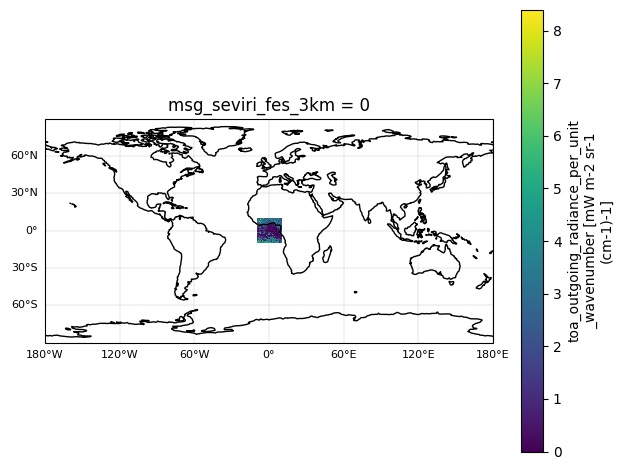

In [68]:
import cartopy.crs as ccrs

# Create a Geostationary projection object
geos_projection = ccrs.Geostationary(central_longitude=0.0, satellite_height=35785831)

# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

ds_c.IR_016.plot.imshow(ax=ax, x="x", y="y", transform=geos_projection)

ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

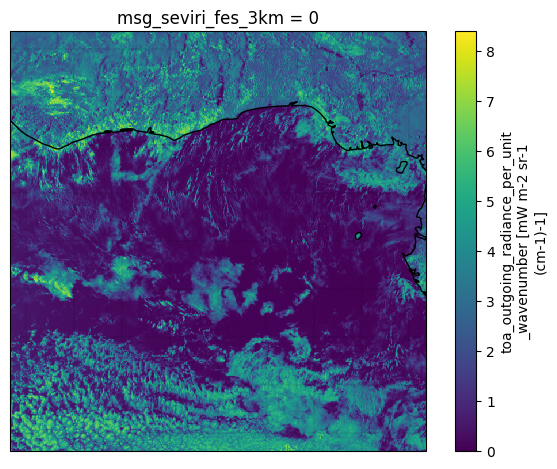

In [73]:
# Create a Geostationary projection object
geos_projection = ccrs.Geostationary(central_longitude=0.0, satellite_height=35785831)

# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=geos_projection)

ds_c.IR_016.plot.imshow(ax=ax, x="x", y="y", transform=geos_projection)

ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=geos_projection, draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()

In [94]:
ds_c

<xarray.Dataset>
Dimensions:             (y: 729, x: 723)
Coordinates: (12/16)
    IR_016_acq_time     (y) datetime64[ns] 2020-10-01T15:05:11.489000 ... 202...
  * y                   (y) float64 -1.092e+06 -1.089e+06 ... 1.092e+06
  * x                   (x) float64 -1.083e+06 -1.08e+06 ... 1.08e+06 1.083e+06
    longitude           (y, x) float64 dask.array<chunksize=(365, 723), meta=np.ndarray>
    latitude            (y, x) float64 dask.array<chunksize=(365, 723), meta=np.ndarray>
    IR_039_acq_time     (y) datetime64[ns] 2020-10-01T15:05:15.104000 ... 202...
    ...                  ...
    IR_134_acq_time     (y) datetime64[ns] 2020-10-01T15:05:15.104000 ... 202...
    VIS006_acq_time     (y) datetime64[ns] 2020-10-01T15:05:11.489000 ... 202...
    VIS008_acq_time     (y) datetime64[ns] 2020-10-01T15:05:11.489000 ... 202...
    WV_062_acq_time     (y) datetime64[ns] 2020-10-01T15:05:15.104000 ... 202...
    WV_073_acq_time     (y) datetime64[ns] 2020-10-01T15:05:15.104000 ... 202...
    msg_seviri_fes_3km  int64 0
Data variables:
    IR_016              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    IR_039              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    IR_087              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    IR_097              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    IR_108              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    IR_120              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    IR_134              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    VIS006              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    VIS008              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    WV_062              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
    WV_073              (y, x) float32 dask.array<chunksize=(365, 723), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2024-03-21 15:13:26.072078
    Conventions:  CF-1.7

In [17]:
def preprocess(ds):

    ds = ds.copy()

    ds = add_msg_crs(ds)
    
    # subset data
    bbox = (-10, -10, 10, 10)
    lon_bnds = (bbox[0], bbox[2])
    lat_bnds = (bbox[1], bbox[3])
    x_bnds, y_bnds = convert_lat_lon_to_x_y(ds_c.rio.crs, lon=lon_bnds, lat=lat_bnds, )
    ds_c = ds_c.sortby("x").sortby("y")
    ds_subset = ds_c.sel(
        y=slice(y_bnds[0], y_bnds[1]),
        x=slice(x_bnds[0], x_bnds[1])
    )
    
    # # resampling
    # resolution = 1_000 # [m]
    # method = "cubic"
    # ds_subset = resample_rioxarray(ds, resolution=resolution, method=method)
    # ds_subset = calc_latlon(ds_subset)

    # assign coordinates
    ds_subset = ds_subset[["Rad", "DQF"]]
    time_stamp = pd.to_datetime(ds.t.values)
    time_stamp = time_stamp.strftime("%Y-%m-%d %H:%M")
    band_attrs = ds.band.attrs
    band_wvl_attrs = ds.band_wavelength.attrs
    ds_subset[["Rad", "DQF"]] = ds_subset[["Rad", "DQF"]].expand_dims({"band":ds.band.values, "time":[time_stamp]})
    ds_subset = ds_subset.drop_vars(["t", "y_image", "x_image", "goes_imager_projection"])
    ds_subset.band.attrs = band_attrs
    ds_subset = ds_subset.assign_coords({"band_wavelength": ds.band_wavelength.values})
    ds_subset.band_wavelength.attrs = band_wvl_attrs

    return ds_subset

In [18]:
%%time
ds = xr.open_mfdataset(
    "/home/juanjohn/data/rs/goes16/raw/noaa-goes16/ABI-L1b-RadF/2018/274/14/OR_ABI-L1b-RadF-M4C02*"
)
ds_subset = preprocess(ds)
ds_subset

CPU times: user 3.26 s, sys: 299 ms, total: 3.56 s
Wall time: 3.29 s


<xarray.Dataset> Size: 150MB
Dimensions:          (band: 1, time: 1, y: 2068, x: 3014, band_wavelength: 1)
Coordinates:
  * x                (x) float64 24kB -4.645e+06 -4.644e+06 ... -1.632e+06
  * y                (y) float64 17kB 5.481e+05 5.471e+05 ... -1.519e+06
    latitude         (y, x) float64 50MB 5.304 5.304 5.304 ... -14.04 -14.04
    longitude        (y, x) float64 50MB -126.8 -126.8 -126.8 ... -90.51 -90.5
  * band             (band) int8 1B 2
  * time             (time) object 8B '2018-10-01 14:02'
  * band_wavelength  (band_wavelength) float32 4B 0.64
Data variables:
    Rad              (band, time, y, x) float32 25MB 0.6443 0.1685 ... nan nan
    DQF              (band, time, y, x) float32 25MB 0.0 0.0 0.0 ... nan nan nan
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 4
    date_created:              2018-10-01T14:05:07.3Z
    time_coverage_start:       2018-10-01T14:00:22.4Z
    time_coverage_end:         2018-10-01T14:05:02.7Z
    id:                        f0161463-ab8d-4e15-91af-890acbb28956

#### Test II - A few Files

In [19]:
file_path = "/home/juanjohn/data/rs/goes16/raw/noaa-goes16/ABI-L1b-RadF/2018/274/14"
files = [
    # Band 1 - 10,848
    f"{file_path}/OR_ABI-L1b-RadF-M4C01_G16_s20182741400224_e20182741405027_c20182741405078.nc",
    # Band 2 - 21,696
    f"{file_path}/OR_ABI-L1b-RadF-M4C02_G16_s20182741400224_e20182741405027_c20182741405073.nc",
    # Band 4 - 5,424
    f"{file_path}/OR_ABI-L1b-RadF-M4C04_G16_s20182741400224_e20182741405028_c20182741405062.nc"
]

In [20]:
%%time
# open
ds = [xr.open_mfdataset(ifile, preprocess=preprocess, concat_dim="band", combine="nested") for ifile in files]
# reinterpolate to match coordinates of first image
ds = [ds[0]] + [ids.interp(x=ds[0].x, y=ds[0].y) for ids in ds[1:]]
# concatentate
ds = xr.concat(ds, dim="band")

CPU times: user 8.56 s, sys: 654 ms, total: 9.21 s
Wall time: 8.8 s


In [24]:
!ls /home/juanjohn/data/rs/goes/analysis

20202761609_goes16.nc  20202762009_goes16.nc


In [30]:
ds_ = xr.open_dataset("/home/juanjohn/data/rs/goes/analysis/20202761609_goes16.nc")
ds_

<xarray.Dataset> Size: 947MB
Dimensions:                          (x: 3014, y: 2067, time: 1,
                                      band_wavelength: 16, band: 16)
Coordinates:
  * x                                (x) float64 24kB -4.645e+06 ... -1.632e+06
  * y                                (y) float64 17kB 5.476e+05 ... -1.518e+06
  * time                             (time) <U16 64B '2020-10-02 16:05'
  * band_wavelength                  (band_wavelength) float32 64B 0.47 ... 1...
  * band                             (band) int8 16B 1 2 3 4 5 ... 13 14 15 16
    latitude                         (y, x) float64 50MB ...
    longitude                        (y, x) float64 50MB ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    twilight_solar_zenith_angle      float32 4B ...
    cloud_mask                       (time, y, x) float64 50MB ...
Data variables:
    Rad                              (band, time, y, x) float32 399MB ...
    DQF                              (band, time, y, x) float32 399MB ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-02T16:09:55.4Z
    time_coverage_start:       2020-10-02T16:00:19.3Z
    time_coverage_end:         2020-10-02T16:09:50.1Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        27062453-6bd0-4259-9de9-28d3b20d7a07

In [29]:
ds_.close()

#### Test III - All The Files

In [21]:
list_of_files = get_list_filenames(file_path, "*.nc")

In [22]:
%%time
# open
ds = [xr.open_mfdataset(ifile, preprocess=preprocess, concat_dim="band", combine="nested") for ifile in list_of_files]
# reinterpolate to match coordinates of first image
ds = [ds[0]] + [ids.interp(x=ds[0].x, y=ds[0].y) for ids in ds[1:]]
# concatentate
ds = xr.concat(ds, dim="band")

CPU times: user 42.5 s, sys: 3.25 s, total: 45.7 s
Wall time: 45.2 s


In [23]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:          (x: 3014, y: 2067, time: 1, band_wavelength: 16, band: 16)
Coordinates:
  * x                (x) float64 24kB -4.645e+06 -4.644e+06 ... -1.632e+06
  * y                (y) float64 17kB 5.476e+05 5.466e+05 ... -1.518e+06
  * time             (time) object 8B '2018-10-01 14:02'
  * band_wavelength  (band_wavelength) float32 64B 0.47 0.64 0.865 ... 12.3 13.3
  * band             (band) int8 16B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    latitude         (band, y, x) float64 797MB 5.299 5.299 ... -14.04 -14.04
    longitude        (band, y, x) float64 797MB -126.8 -126.8 ... -90.5 -90.49
Data variables:
    Rad              (band, time, y, x) float64 797MB 0.8629 0.8629 ... nan nan
    DQF              (band, time, y, x) float64 797MB 0.0 0.0 0.0 ... nan nan
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    Realtime
    timeline_id:               ABI Mode 4
    date_created:              2018-10-01T14:05:07.8Z
    time_coverage_start:       2018-10-01T14:00:22.4Z
    time_coverage_end:         2018-10-01T14:05:02.7Z
    id:                        6386f771-1da9-4d21-bab8-2db1b54c6cc5

## Stage 3

* Normalization
* Patching

#### Running Mean

In [25]:
save_dir_analysis = "/home/juanjohn/data/rs/goes16/analysis/"

In [26]:
def mean_preprocess(ds):
    # calculate the mean
    ds = ds["Rad"].mean(["x", "y"])
    return ds

In [27]:
ds_mean = xr.open_mfdataset(str(Path(save_dir_analysis).joinpath("*.nc")), preprocess=mean_preprocess, concat_dim="time", combine="nested")

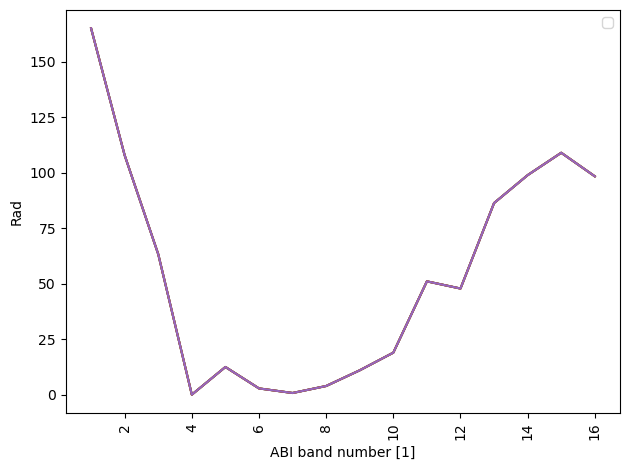

In [28]:
fig, ax = plt.subplots()
ds_mean.plot.line(x="band", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [29]:
ds_mean = ds_mean.mean(["time"])

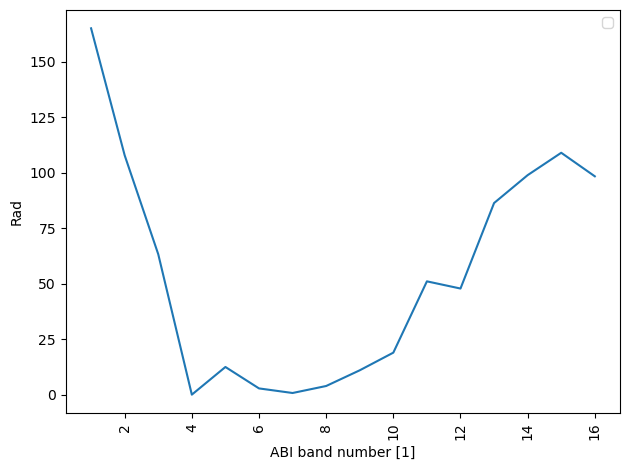

In [30]:
fig, ax = plt.subplots()
ds_mean.plot.line(x="band", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [31]:
def std_preprocess(ds):
    # calculate the mean
    ds = ((ds.Rad - ds_mean)**2).std(["x","y"])
    return ds

In [32]:
ds_std = xr.open_mfdataset(str(Path(save_dir_analysis).joinpath("*.nc")), preprocess=std_preprocess, concat_dim="time", combine="nested")

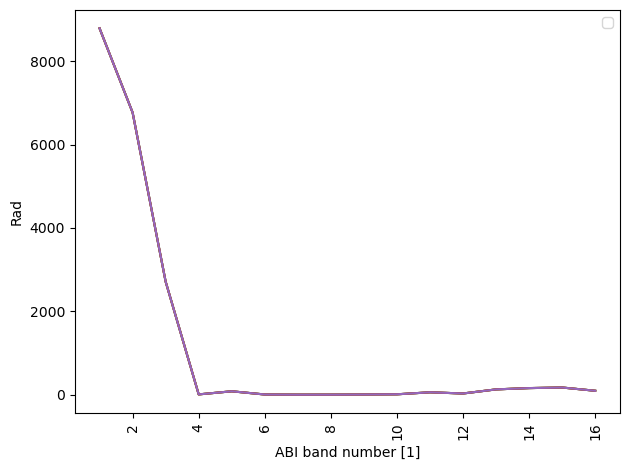

In [33]:
fig, ax = plt.subplots()
ds_std.plot.line(x="band", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [34]:
ds_std = ds_std.mean(["time"])

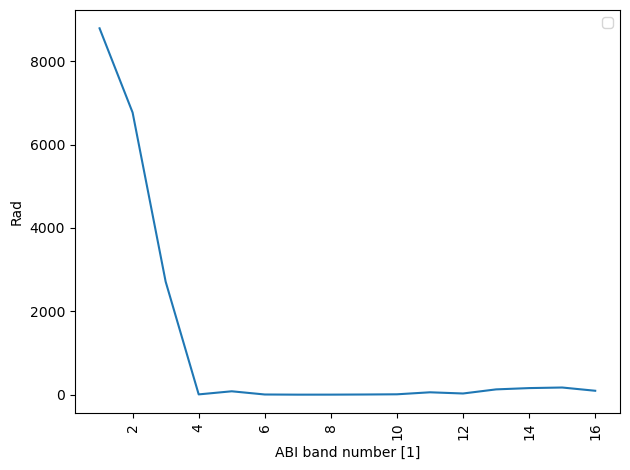

In [35]:
fig, ax = plt.subplots()
ds_std.plot.line(x="band", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

### Patching

In [36]:
from xrpatcher._src.base import XRDAPatcher

In [37]:
patches = dict(x=256, y=256)
strides = dict(x=64, y=64)
patcher = XRDAPatcher(da=ds.Rad, patches=patches, strides=strides)

In [38]:
len(patcher)

1276

In [39]:
ipatch = patcher[0]
ipatch

<xarray.DataArray 'Rad' (band: 16, time: 1, y: 256, x: 256)> Size: 8MB
array([[[[  0.86286354,   0.86286354,   0.86286354, ...,  13.04445839,
           13.04445839,  13.04445839],
         [  0.86286354,   0.86286354,   0.86286354, ...,  13.04445839,
           13.04445839,  13.04445839],
         [  0.86286354,   0.86286354,   0.86286354, ...,  13.04445839,
           13.04445839,  13.04445839],
         ...,
         [  1.67496872,   1.67496872,   0.86286354, ...,  14.66867256,
           14.66867256,  15.48077583],
         [  1.67496872,   1.67496872,   1.67496872, ...,  15.48077583,
           15.48077583,  14.66867256],
         [  0.86286354,   1.67496872,   0.86286354, ...,  14.66867256,
           14.66867256,  14.66867256]]],


       [[[  0.40585485,   0.32745574,   0.60445339, ...,   5.7194189 ,
            5.75942312,   5.87711209],
         [  0.56480587,   0.40675145,   0.48586897, ...,   5.87818931,
            5.71816058,   5.44152303],
         [  0.60373612,   0.3665658 ,   0.68482795, ...,   6.07606896,
...
          116.66930389, 115.03455078],
         [         nan, 117.19704437, 117.2498035 , ..., 116.66910301,
          116.66930389, 115.5085649 ],
         [         nan, 117.19713698, 117.24961835, ..., 116.66891787,
          116.66911866, 115.50856485]]],


       [[[         nan,  96.52262878,  96.52262878, ...,  99.3391633 ,
           99.3392525 ,  98.98784019],
         [         nan,  96.52262878,  96.52262878, ...,  99.16350555,
           99.16350555,  99.16350555],
         [         nan,  96.52293774,  96.52293774, ...,  99.1635054 ,
           99.16350555,  99.16350555],
         ...,
         [         nan,  97.75441747,  97.75503524, ...,  98.98766148,
           98.98775099,  98.81112198],
         [         nan,  97.40291595,  97.75494604, ...,  99.16332684,
           99.16350555,  98.63546424],
         [         nan,  97.40353388,  97.75463732, ...,  99.163327  ,
           99.16350555,  98.63577312]]]])
Coordinates:
  * x        (x) float64 2kB -4.645e+06 -4.644e+06 ... -4.391e+06 -4.39e+06
  * y        (y) float64 2kB 5.476e+05 5.466e+05 ... 2.936e+05 2.926e+05
  * time     (time) object 8B '2018-10-01 14:02'
  * band     (band) int8 16B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

In [63]:

for i, ipatch in enumerate(patcher):
    # save as numpy files
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_reflectance_patch_{i}.npz"), ipatch.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_latitude_patch_{i}.npz"), ipatch.latitude.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_longitude_patch_{i}.npz"), ipatch.longitude.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_cloudmask_patch_{i}.npz"), ipatch.cloud_mask.values)
    break

In [46]:
mldata_dir = Path("/home/juanjohn/data/rs/goes16/mlready")

In [47]:
# !ls $mldata_dir

## Datasets, DataLoaders

In [40]:
from torch.utils.data import Dataset, DataLoader
from typing import Optional, Callable

In [88]:
class ImageDataReader(Dataset):
    def __init__(self, data_dir: str, ext: str=".npy", transforms: Optional[Callable]=None):
        self.data_dir = data_dir
        data_filenames = get_list_filenames(data_dir, ext)
        # filter files
        self.data = list(filter(lambda x: "reflectance" in x, data_filenames))
        self.lats = list(filter(lambda x: "latitude" in x, data_filenames))
        self.lons = list(filter(lambda x: "longitude" in x, data_filenames))
        self.masks = list(filter(lambda x: "cloudmask" in x, data_filenames))
        assert len(self.data) == len(self.lats) == len(self.lons) == len(self.masks)
        self.transforms = transforms

    def __getitem__(self, ind) -> np.ndarray:
        sample = {}
        sample["data"] = np.load(self.data[ind], mmap_mode="r+")
        sample["lats"] = np.load(self.lats[ind], mmap_mode="r+")
        sample["lons"] = np.load(self.lons[ind], mmap_mode="r+")
        sample["mask"] = np.load(self.masks[ind], mmap_mode="r+")
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample

    def __len__(self):
        return len(self.data)

In [89]:
ds = ImageDataReader("/home/juanjohn/data/rs/modis/mlready")

In [87]:
isample = ds[0]

#### DataLoader

In [83]:
dl = DataLoader(ds, batch_size=64, shuffle=False)

In [84]:
for isample in dl:
    break

In [85]:
isample["data"].shape

torch.Size([64, 1, 38, 256, 256])